# Necessary Libraries (only need to be ran once, it will take approx. 5-10 minutes)

In [1]:
#spacy
!python -m spacy download es_core_news_lg
!python -m spacy download ca_core_news_lg
import spacy
import es_core_news_lg
import ca_core_news_lg

#create data frame and count words
import numpy as np
from collections import Counter
import pandas as pd
import math
import re

#create visualizations
import matplotlib.pyplot as plt

#get files
!pip install --upgrade gdown
import gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.0/574.0 MB 1.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [2]:
#download concordance files
!gdown 1eZcCqq5LkzRE0anV-lVPjmIVOxgjq0Up

!unzip "tfm_test_lemma.zip"

!gdown 1ZCov-5N8jO2BZDguOFLB_CGVS8orkdKo

Downloading...
From: https://drive.google.com/uc?id=1eZcCqq5LkzRE0anV-lVPjmIVOxgjq0Up
To: /content/tfm_test_lemma.zip
100% 24.1M/24.1M [00:00<00:00, 77.5MB/s]
Archive:  tfm_test_lemma.zip
   creating: tfm test lemma/
  inflating: tfm test lemma/vaca2023.txt  
  inflating: __MACOSX/tfm test lemma/._vaca2023.txt  
  inflating: tfm test lemma/muro2023.txt  
  inflating: __MACOSX/tfm test lemma/._muro2023.txt  
  inflating: tfm test lemma/grande2023.txt  
  inflating: __MACOSX/tfm test lemma/._grande2023.txt  
  inflating: tfm test lemma/rearmar2023.txt  
  inflating: __MACOSX/tfm test lemma/._rearmar2023.txt  
  inflating: tfm test lemma/arena2023.txt  
  inflating: __MACOSX/tfm test lemma/._arena2023.txt  
  inflating: tfm test lemma/abrir1975.txt  
  inflating: __MACOSX/tfm test lemma/._abrir1975.txt  
  inflating: tfm test lemma/pinguino1975.txt  
  inflating: __MACOSX/tfm test lemma/._pinguino1975.txt  
  inflating: tfm test lemma/viral2023.txt  
  inflating: __MACOSX/tfm test lemma/.

In [3]:
#to get FastText embeddings, PCA transform, reduced dim
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import numpy as np

!pip install gensim matplotlib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors

!wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz"
!gunzip cc.es.300.vec.gz

embedding_path = 'cc.es.300.vec'
model = KeyedVectors.load_word2vec_format(embedding_path, limit=500000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2024-06-23 09:47:44--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz’

cc.es.300.vec.gz    100%[===================>]   1.20G  73.9MB/s    in 15s     

2024-06-23 09:48:00 (80.2 MB/s) - ‘cc.es.300.vec.gz’ saved [1285580896/1285580896]



# (functions, only need to be ran once)

In [4]:
def open_file(file_name):
    """
    Opens the txt file obtained from CORPES/CREA, skips the first rows with the search query
    data and creates a data frame with the concordances. Keeping only the necessary
    columns for this research (FECHA and CONCORDANCIA).

    Parameters:
        TXT file: Input a .txt file where the columns are separated by tabulation.

    Returns:
        df (DataFrame): A data frame with the concordances of the word and the
            corresponding year.
    """

    df = pd.read_csv(file_name, sep='\t', on_bad_lines = 'warn', quoting=3, skiprows=7)

    hide_columns = ['BIBLIOGRAFÍA', 'AUTOR', 'TÍTULO', 'CRITERIO', 'BLOQUE', 'MEDIO', 'SOPORTE', 'TEMA', 'PAÍS','ZONA', 'TIPOLOGÍA', 'NOTAS']
    df = df.drop(columns=hide_columns)
    df['FECHA'] = pd.to_numeric(df['FECHA'], errors='coerce').astype('Int64')
    #Int64 is used in case one row is empty skip it
    df['CONCORDANCIA'] = df['CONCORDANCIA'].astype(str)

    return df

In [5]:
#we load the specific language library
nlp = es_core_news_lg.load()

def lemmatize_data(text):
    """ Lemmatize all words in a string that are not stopwords or punctuation

    Parameters:
        text string: Input a text string

    Returns:
        text string: a new string with the resulting lemmas. """
    text = re.sub(r'[^a-zA-ZáàéèíìóòúùüÁÀÉÈÍÌÓÒÚÙÜñÑçÇ]', " ", text)
    doc = nlp(text.lower())  # Process text with spaCy and convert to lowercase
    #lemmatize but only keep nouns
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.pos_ == 'NOUN'])
    return lemmatized_text

In [6]:
nlp_ca = ca_core_news_lg.load()

def lemmatize_data_ca(text):
    """ Lemmatize all words in a string that are not stopwords or punctuation

    Parameters:
        text string: Input a text string

    Returns:
        text string: a new string with the resulting lemmas. """
    text = re.sub(r'[^a-zA-ZáàéèíìóòúùüÁÀÉÈÍÌÓÒÚÙÜñÑçÇ]', " ", text)
    doc = nlp_ca(text.lower())  # Process text with spaCy and convert to lowercase
    #lemmatize but only keep nouns
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.pos_ == 'NOUN'])
    return lemmatized_text

In [7]:
def count_words(df):
    """
    Count the absolute frequency of all words from the lemmatized data frame

    Parameters:
        df (DataFrame): Input a df that has a column named ['lemmatized_text']
            with the sting you want to count.

    Returns:
        list: A list of tuples containing the words and their absolute frequency.
    """

    # we create a counter
    word_counts = Counter()

    # because it is a df we want to go over all the rows and go over the lemmatized string
    for index, row in df.iterrows():
        lemmatized_text = row['lemmatized_text']

        # we split the sting into individual words and update our counter with the new counts
        word_counts.update(lemmatized_text.split())

    # we transform the counter into a list, this list will contain tuples (word + number count)
    word_occurrences = list(word_counts.items())

    # for better observation we sort the list from highest count to lowest
    word_occurrences.sort(key=lambda x: x[1], reverse=True)

    return word_occurrences

In [8]:
def calculate_relative_frequency(word_occurrences):
    """
    Calculate the relative frequency of each word.

    Parameters:
        list: A list of tuples containing words and their absolute frequency.

    Returns:
        dict: A dictionary where keys are the words and values are their relative frequencies.
    """
    # we get the total amount of words in the list
    total_count = sum(count for word, count in word_occurrences)
    # for each word we divide the frecuency by the total count of words to obtain the relative frequency
    relative_frequency = {word: count / total_count for word, count in word_occurrences}

    return relative_frequency

In [9]:
def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler (KL) divergence between the two corpus.

    Parameters:
        p (dict): Dictionary with words and relative frequency obtained from the oldest corpus
        q (dict): Dictionary with words and relative frequency obtained from the newest corpus

    Returns:
        float: Final KL divergence between the two corpus.
    """
    #in case the parameters obtained are not dictionaries but lists
    p_dict = dict(p)
    q_dict = dict(q)

    # we want all the unique keys from both dictionaries
    all_keys = set(p_dict.keys()) | set(q_dict.keys())
    # if one of the words doesn't exist in one of dictionries, it is added with a value of 0.0001 to make the division possible
    for word in all_keys:
        p_dict.setdefault(word, 0.0001)
        q_dict.setdefault(word, 0.0001)

    # we calculate the kl divergence of both dictionaries.
    divergence = sum(p_dict[word] * math.log(p_dict[word] / q_dict[word]) for word in all_keys if p_dict[word] != 0 and q_dict[word] != 0)

    return divergence


In [10]:
def plot_year_occurrences(df, year_column, neologism):
    """
    Plots the number of occurrences per year from a specific DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        year_column (str): The name of the column containing the year data.
        neologism (str): The current target word being analyzed.
    """
    # Count the occurrences of each year
    year_counts = df[year_column].value_counts().sort_index()

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(year_counts.index, year_counts.values, marker='o')
    plt.title(f'Number of Occurrences Per Year of "{neologism}"')
    plt.xlabel('Year')
    plt.ylabel('Number of Occurrences')
    plt.grid(True)
    plt.show()

In [11]:
def get_top_words(df, word_to_skip, top_n=20):
    """
    Plots the total number of occurrences from a specific DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        word_to_skip (str): The current target word being analyzed.
        top_n (int): Number of top words you want to show.
    """
    # Tokenize the lemmatized text
    df['word'] = df['lemmatized_text'].apply(word_tokenize)

    # Explode the DataFrame to have one row per token
    exploded_df = df.explode('word')

    # Group by 'word' and count occurrences
    frequency_df = exploded_df.groupby('word').size().reset_index(name='frequency')

    # Sort the frequencies in descending order to show higher frequencies first
    frequency_df = frequency_df.sort_values(by='frequency', ascending=False)

    # Filter out the target word / neologism
    filtered_frequency_df = frequency_df[frequency_df['word'] != word_to_skip]

    # Get the specified number of top words
    top_words = filtered_frequency_df.head(top_n)

    return top_words

#a simple function to return the printing of the words in a more readable form

def get_and_print_top_words(df_1975, df_2023, word_to_skip, get_top_words):

    top_words_1975 = get_top_words(df_1975, word_to_skip)
    top_words_2023 = get_top_words(df_2023, word_to_skip)
    print("Top words for Reference file:")
    print(top_words_1975)
    print("-----------------------")
    print("Top words for Current file:")
    print(top_words_2023)
    print("-----------------------")

    return top_words_1975, top_words_2023


def get_embeddings(word_list, model):
    """
    Get the embeddings of a specific list of words.

    Parameters:
        word_list (list): The list of words of which you want the embeddings
        model : The specific model you want to use to extract the embeddings.
    """
    embeddings = []
    valid_words = []
    #we go through each word in the list, if the word is in the model we save its embedding and also the string with the word
    for word in word_list:
        if word in model:
            embeddings.append(model[word])
            valid_words.append(word)
    return embeddings, valid_words

def scale_embeddings(embeddings, x_range=(-9, 4), y_range=(-9, 9)):
    """
    From a list of embeddings we scale them to fit a plot.

    Parameters:
        embeddings (list): The list of words embeddings.
        x_range : The specific x axis range you want to fit.
        y_range : The specific y axis range you want to fit.
    """
    x_min, x_max = x_range
    y_min, y_max = y_range
    embeddings_min = embeddings.min(axis=0)
    embeddings_max = embeddings.max(axis=0)

    # Scale to [0, 1]
    embeddings_scaled = (embeddings - embeddings_min) / (embeddings_max - embeddings_min)

    # Scale to the desired range
    embeddings_scaled[:, 0] = embeddings_scaled[:, 0] * (x_max - x_min) + x_min
    embeddings_scaled[:, 1] = embeddings_scaled[:, 1] * (y_max - y_min) + y_min

    return embeddings_scaled

In [12]:
def plot_word_embeddings(top_words_1975, top_words_2023, neo, model, get_embeddings, scale_embeddings):
    """
    Create a 2D scatter plot with the top co-occuring words in both concordance files.

    Parameters:
        top_words_1975 (list) : The list with the Reference file top words.
        top_words_2023 (list) : The list with the Current file top words.
        neo (str) : The target word we are analyzing.
        model : the specific model you want to use.
        get_embeddings (func) : A function to collect word embeddings of a list of words.
        scale_embeddings (func) : A fucntion that scales an embedding to fit a plot.
    """
    #we make sure we are using a list
    top_words_1975_list = top_words_1975['word'].tolist()
    top_words_2023_list = top_words_2023['word'].tolist()

    #we get the embeddings of top words that appear in the model and keep the embedding and the list of words
    embeddings_1975, valid_words_1975 = get_embeddings(top_words_1975_list, model)
    embeddings_2023, valid_words_2023 = get_embeddings(top_words_2023_list, model)

    #we merge both the lists of embeddings and word from both files
    all_embeddings = embeddings_1975 + embeddings_2023
    all_words = valid_words_1975 + valid_words_2023
    #we link each list to its label
    labels = ['Reference'] * len(embeddings_1975) + ['Current'] * len(embeddings_2023)

    # we convert the lists to numpy arrays
    all_embeddings_np = np.array(all_embeddings)
    labels_np = np.array(labels)

    # we reduce the dimensionality using PCA transformation
    pca = PCA(n_components=min(all_embeddings_np.shape[1], 40))
    embeddings_pca = pca.fit_transform(all_embeddings_np)
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings_pca)

    # we scale the embeddings so they all fit the plot
    embeddings_2d_scaled = scale_embeddings(embeddings_2d)

    # we plot the embeddings
    plt.figure(figsize=(12, 8))
    # we make sure all embeddings appear with colors based on the labels
    for label, color in zip(set(labels_np), ['blue', 'yellow']):
        indices = np.where(labels_np == label)[0]
        plt.scatter(embeddings_2d_scaled[indices, 0], embeddings_2d_scaled[indices, 1], c=color, label=label)

    # we annotate the words
    for i, word in enumerate(all_words):
        plt.annotate(word, xy=(embeddings_2d_scaled[i, 0], embeddings_2d_scaled[i, 1]), fontsize=9)

    # we set fix limits so all plots are the same size
    plt.xlim(-10, 5)
    plt.ylim(-10, 10)

    plt.legend()
    plt.title(f'Embeddings of Top Words around "{neo}" (Reference vs Current)')
    plt.show()

# Loading file and creating Data Frame (CREA/CORPES)

In the space below introduce the name of the term you want to check from the list below (without accentuation or capital letters) so the specific data frames with the concordances can be created.

AVAILABLE CONCORDANCE FILES FOR SPANISH:

agua, alérgico, barbie, bizarro, blanquear, camisa, casa, cuenta, hibernar, ingrediente, lámpara, muro, nube, país, perfil, pingüino, plataforma, seguidor, sofá, televisión, tóxico, tsunami, unicornio, ventana, viral, vaso

abridor, abrir, apagón, árbol, arena, barato, barracón, breve, burbuja, caballo, campamento, cielo, clonar, construir, contento, decir, desahogar, descomprimir, enlace, etiqueta, flor, galáctico, gatillar, generoso, grande, húmedo, icono, instalación, java, levantar, liberar, llave, máscara, metal, nuevo, paisa, peligroso, pintar, pitufo, playa, postear, rearmar, remolcar, seguir, sentir, sesión, sol, termómetro, vaca, virtual



In [13]:
neo = "galactico" # @param {type:"string"}

corpus_1975 = "/content/tfm test lemma/" + str(neo) + "1975.txt"
corpus_2023 = "/content/tfm test lemma/"+ str(neo) + "2023.txt"
df_1975 = open_file(corpus_1975)
df_2023 = open_file(corpus_2023)

In [14]:
#to check if the data frame has been created correctly
print(df_1975)

     FECHA                                       CONCORDANCIA
0     1977  Biólogos de Francia, Rumania y la Unión Soviét...
1     1977  No se trata de apocalípticas batallas entre mo...
2     1977  la princesa Leia se enfrenta al Caballero Negr...
3     1977  Un público compuesto en su mayoría de adultos ...
4     1978  Nuestro Sol es una estrella que habita el subu...
..     ...                                                ...
125   2000  extranjeros para estudiar observacionalmente l...
126   2000  cabo una amplia variedad de observaciones de o...
127   2000  la caracterización, diseño de modos de operaci...
128   2000  las camisas vaqueras con los pendientes y los ...
129   2000  El viajero sideral que me eligió es —para mí— ...

[130 rows x 2 columns]


In [15]:
#in case I want to look for a test concordance

df_1975["CONCORDANCIA"][1]

'No se trata de apocalípticas batallas entre monstruos habitantes de Andrómeda y valerosos guerreros terrestres, las brillantes sagas galácticas de la ópera-space, Diego Valor y Luchadores del espacio como aportaciones ibéricas, han quedado relegadas a mero material de coleccionistas y el género ha ido entretejiendo sus mitos y sus símbolos en las más sofisticadas direcciones. La ciencia-ficción siempre ha tenido mala prensa en cuanto a sus aportaciones literarias y el enconado entusiasmo de sus fans no ha parado'

In [ ]:
df_2023["CONCORDANCIA"][3]

# Lematization, word counting and KL

In [16]:
#check the number of concordances in each file
print(len(df_1975))
print(len(df_2023))

130
1001


In [17]:
""" First we preprocess the data by creating a new column in the data frame with
the context lemmatized and keeping only nouns """

df_1975['lemmatized_text'] = df_1975['CONCORDANCIA'].apply(lemmatize_data)
df_2023['lemmatized_text'] = df_2023['CONCORDANCIA'].apply(lemmatize_data)

#if you want to check the new df structure:
#df_1975

""" We continue counting the absolute frequency of each of the words in the context
of the possible neologism"""

word_occurrences_1975 = count_words(df_1975)
word_occurrences_2023 = count_words(df_2023)

#check if it worked
#for word, frequency in word_occurrences_1975[:50]:
    #print(f"{word}: {frequency}")

""" Once we obtained the ablsoute frequency of each word we calculate its relative frequency
to each corpus """
relative_frequency_1975 = calculate_relative_frequency(word_occurrences_1975)
relative_frequency_2023 = calculate_relative_frequency(word_occurrences_2023)

#based on results observed we establish two thresholds for the code to guess the probaility of it being a semantic neologism
threshold_SN = 0.6
threshold_prob = 0.4

p = relative_frequency_1975
q = relative_frequency_2023

""" Finally, we calculate the KL divergence between both files and print an
assessment of the probability of the term being a semantic neologism or not. """

kl_div = kl_divergence(p, q)
print("KL Divergence:", kl_div)

if kl_div >= threshold_SN:
    print("\nHigh probabilities of this term being a semantic neologism.")
elif kl_div >= threshold_prob:
    print("\nIt is possible this term is either a semantic neologism or a word that has suffered a big contextual change.")
else:
    print("\nThis word has not suffered much contextual change. Indicating that the chances of it being a (recent) semantic neologism are very low.")

KL Divergence: 0.9087599459512532

High probabilities of this term being a semantic neologism.


# Top co-occurrences + plot

In [ ]:
"""To calculate the top words that co-occur with the target word per year"""
# we merge the two data frames
frames = [df_1975, df_2023]
merged_df = pd.concat(frames)

# we tokanize the words
merged_df['word'] = merged_df['lemmatized_text'].apply(word_tokenize)

# we explode the df to have only one row per token
exploded_df = merged_df.explode('word')

# we group by 'FECHA' (year) and 'word', and count occurrences
frequency_df = exploded_df.groupby(['FECHA', 'word']).size().reset_index(name='frequency')

# we sort the frequencies in descending order (highest to lowest) for each year
frequency_df = frequency_df.sort_values(by=['FECHA', 'frequency'], ascending=[True, False])

# define the word to skip = the neologism or target word
word_to_skip = neo

# we group by 'FECHA' and get top 15 words for each year, skipping the specified word
top_words_by_year = frequency_df.groupby('FECHA').apply(lambda x: x[x['word'] != word_to_skip].head(15))

# Print each year and its top 15 words
for year, group in top_words_by_year.groupby(level=0):
    print(f"Year: {year}")
    print()
    print(group[['word', 'frequency']].reset_index(drop=True))
    print("-----------------------")
    print()

#to check the average number of words per concordance in each file

#merged_df['word_count'] = merged_df['CONCORDANCIA'].apply(lambda x: len(x.split()))
#average_word_count = merged_df['word_count'].mean()
#print(f"The average number of words is: {average_word_count}")

Year: 1977

          word  frequency
0        color          3
1       doctor          3
2         aire          2
3      desecho          2
4   excremento          2
5       frasco          2
6        orina          2
7          pub          2
8         raza          2
9     aduanero          1
10      animal          1
11    ausencia          1
12   autoridad          1
13         ave          1
14        café          1
-----------------------

Year: 1978

            word  frequency
0          calle          2
1          forma          2
2       amudscia          1
3           cama          1
4      concierto          1
5           copa          1
6        cristal          1
7         devoto          1
8     escaparate          1
9       estómago          1
10          frío          1
11        hierro          1
12         horno          1
13   instrumento          1
14  manipulación          1
-----------------------

Year: 1980

         word  frequency
0       calle          2


In [ ]:
"""We print the top co-occurring words of each concordance file"""
top_words_1975, top_words_2023 = get_and_print_top_words(df_1975, df_2023, word_to_skip, get_top_words)

Top words for 1975:
             word  frequency
285        cuerno         24
50         animal         15
637          mano         12
601          león         11
185          caso         11
750           ojo         10
1059       tiempo         10
216        ciudad         10
824           pie          9
540         hotel          9
428   experiencia          9
732          niño          9
689       momento          9
462        frente          8
825        piedra          8
146         calle          8
744          obra          8
702         mundo          8
602         libro          8
113        bestia          7
-----------------------
Top words for 2023:
          word  frequency
752     cuerno        102
236        año         89
960    empresa         66
1808    millón         62
116     animal         61
1872     mundo         48
2720    tiempo         43
1867     mujer         38
923    dólares         37
2878      vida         34
1621     libro         34
367    caballo 

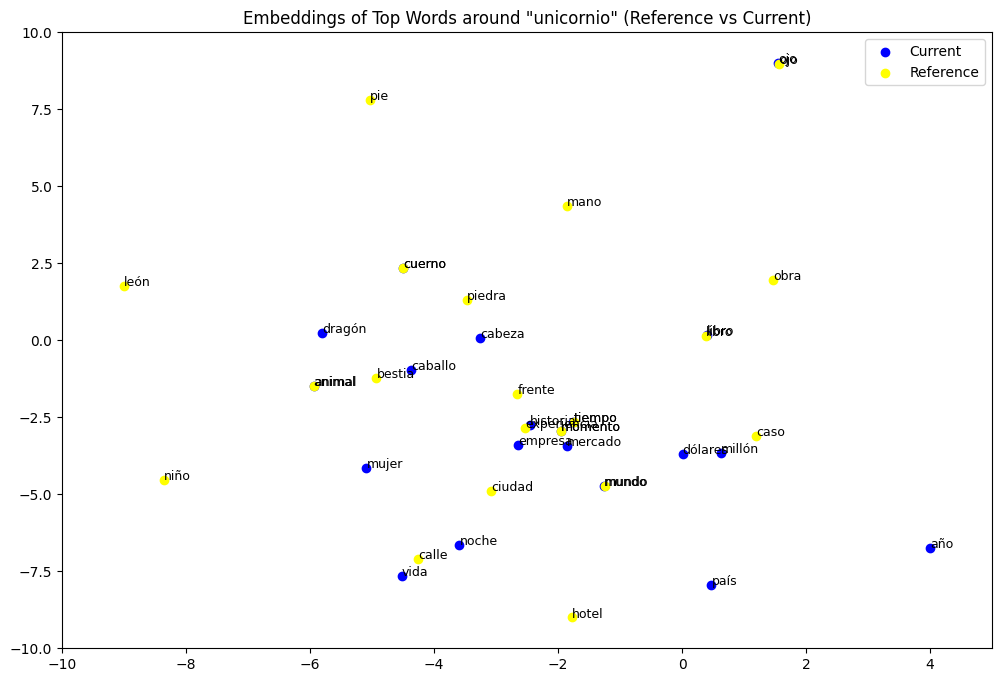

In [ ]:
plot_word_embeddings(top_words_1975, top_words_2023, word_to_skip, model, get_embeddings, scale_embeddings)

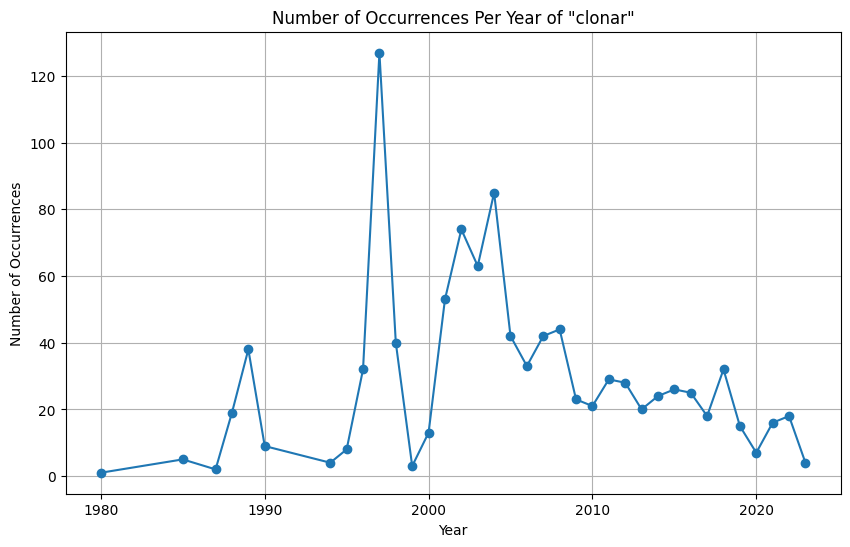

In [ ]:
plot_year_occurrences(merged_df, 'FECHA', neo)

# CTILC

In [ ]:
file_path = "/content/concordances_M_Estruch.xlsx"

# Read the Excel file into a pandas DataFrame
xls = pd.ExcelFile(file_path)

# Parse each sheet into a DataFrame
sheet_names = xls.sheet_names
data = {}
for sheet_name in sheet_names:
    column_names = ['indx','info', 'before', 'neo', 'after']
    # Read the sheet into a DataFrame with specified column names
    data[sheet_name] = pd.read_excel(xls, sheet_name, names=column_names)

In [ ]:
# Now you can access each DataFrame by its sheet name
# For example, data['Sheet1'] will give you the DataFrame for the 'Sheet1' tab

neo = "plataforma" # @param {type:"string"}

# Example usage:
current_df = "conc_" + str(neo)
df = data[current_df]
#print(df)
df.reset_index(drop=True, inplace=True)

df['FECHA'] = df['info'].astype(str).str.extract(r'(\d{4})$', expand=False)

df['CONCORDANCIA'] = df['before'].astype(str) + ' ' + df['neo'] + ' ' + df['after']
df['CONCORDANCIA'] = df['CONCORDANCIA'].astype(str)
columns_to_drop = ['indx','info', 'before', 'neo', 'after']
df = df.drop(columns=columns_to_drop)

df['FECHA'] = pd.to_numeric(df['FECHA'], errors='coerce')

# Create two DataFrames based on the year
df_old = df[df['FECHA'] < 2000]
df_new = df[df['FECHA'] >= 2000]
#limit the reference corpus so the period of time analyzed are almost the same size
df_old = df_old[df_old['FECHA'] >= 1970]

print(len(df_old))
print(len(df_new))

664
1080


In [ ]:
df_old.loc[:, 'lemmatized_text'] = df_old['CONCORDANCIA'].apply(lemmatize_data_ca)
df_new.loc[:, 'lemmatized_text'] = df_new['CONCORDANCIA'].apply(lemmatize_data_ca)

word_occurrences_old = count_words(df_old)
word_occurrences_new = count_words(df_new)

relative_frequency_old = calculate_relative_frequency(word_occurrences_old)
relative_frequency_new = calculate_relative_frequency(word_occurrences_new)

threshold_SN = 0.2
threshold_prob = 0.15

p = relative_frequency_old
q = relative_frequency_new


<ipython-input-20-c5e8baa36d60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.loc[:, 'lemmatized_text'] = df_new['CONCORDANCIA'].apply(lemmatize_data_ca)


In [ ]:
kl_div = kl_divergence(p, q)
print("KL Divergence:", kl_div)

if kl_div >= threshold_SN:
    print("\nHigh probabilities of this term being a semantic neologism.")
elif kl_div >= threshold_prob:
    print("\nIt is possible this term is either a semantic neologism or a word that has suffered a big contextual change.")
else:
    print("\nThis word has not suffered much contextual change. Indicating that the chances of it being a (recent) semantic neologism are very low.")


KL Divergence: 0.2773191572084069

High probabilities of this term being a semantic neologism.


In [ ]:
frames = [df_old, df_new]
merged_df = pd.concat(frames)
merged_df['word'] = merged_df['lemmatized_text'].apply(word_tokenize)

# Explode the DataFrame to have one row per token
exploded_df = merged_df.explode('word')

# Group by 'year' and 'tokens', and count occurrences
frequency_df = exploded_df.groupby(['FECHA', 'word']).size().reset_index(name='frequency')

# Sort the frequencies in descending order for each year
frequency_df = frequency_df.sort_values(by=['FECHA', 'frequency'], ascending=[True, False])

# Define the word to skip
word_to_skip = neo

# Group by 'year' and get top 10 words for each year, skipping the specified word
top_10_words_by_year = frequency_df.groupby('FECHA').apply(lambda x: x[x['word'] != word_to_skip].head(15))

# Print each year and its top 10 words
for year, group in top_10_words_by_year.groupby(level=0):
    print(f"Year: {year}")
    print()
    print(group[['word', 'frequency']].reset_index(drop=True))
    print("-----------------------")
    print()

#merged_df['word_count'] = merged_df['CONCORDANCIA'].apply(lambda x: len(x.split()))
#average_word_count = merged_df['word_count'].mean()
#print(f"The average number of words is: {average_word_count}")

Year: 1970

           word  frequency
0   preocupació          2
1        aiguat          1
2       atenció          1
3   autonomista          1
4       barreta          1
5       bastida          1
6           cap          1
7           cas          1
8          casa          1
9           cel          1
10       cercle          1
11         cert          1
12       comerç          1
13     confusió          1
14    connectiu          1
-----------------------

Year: 1971

          word  frequency
0      relació          2
1        aigua          1
2         amor          1
3        arbre          1
4   bonhoeffer          1
5       branca          1
6      cadàver          1
7        canvi          1
8       cercle          1
9      creença          1
10       còdol          1
11  degradació          1
12     dessota          1
13       dubte          1
14      espart          1
-----------------------

Year: 1972

          word  frequency
0   adquisició          1
1      caragol

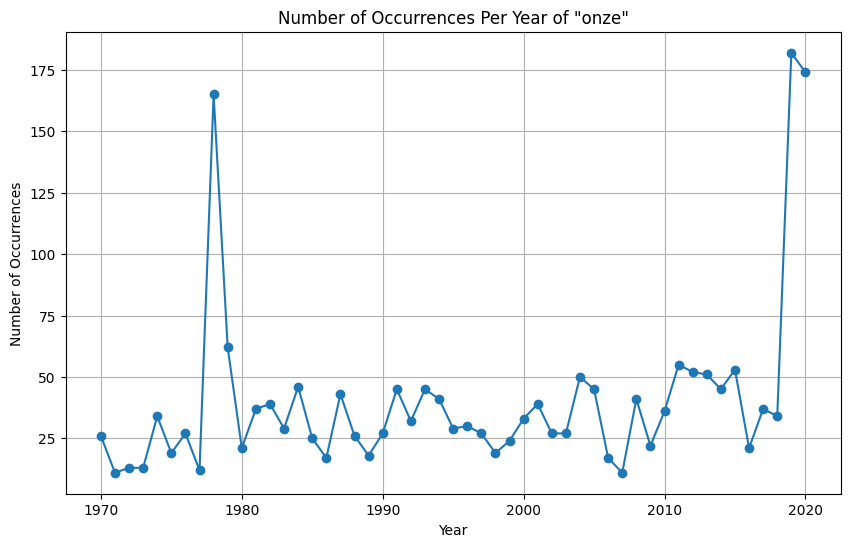

In [ ]:
plot_year_occurrences(merged_df, 'FECHA', neo)